In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#inceptionV3 - 2class 학습(ciga, vape) - original

In [2]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=128, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=128, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=128, class_mode='binary')

Found 12030 images belonging to 2 classes.
Found 1156 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

87910968/87910968 [==============================] - 0s 0us/step


In [4]:
# 모델 학습
history = model.fit(train_generator, epochs=30, validation_data=valid_generator)

Epoch 1/30
94/94 [==============================] - 1776s 19s/step - loss: 0.5076 - accuracy: 0.8173 - val_loss: 0.3021 - val_accuracy: 0.8702
Epoch 2/30
94/94 [==============================] - 87s 929ms/step - loss: 0.2050 - accuracy: 0.9148 - val_loss: 0.2722 - val_accuracy: 0.8884
Epoch 3/30
94/94 [==============================] - 88s 934ms/step - loss: 0.1678 - accuracy: 0.9324 - val_loss: 0.2870 - val_accuracy: 0.8858
Epoch 4/30
94/94 [==============================] - 87s 924ms/step - loss: 0.1485 - accuracy: 0.9399 - val_loss: 0.2787 - val_accuracy: 0.8867
Epoch 5/30
94/94 [==============================] - 87s 921ms/step - loss: 0.1302 - accuracy: 0.9484 - val_loss: 0.3433 - val_accuracy: 0.8685
Epoch 6/30
94/94 [==============================] - 87s 920ms/step - loss: 0.1022 - accuracy: 0.9624 - val_loss: 0.2515 - val_accuracy: 0.8988
Epoch 7/30
94/94 [==============================] - 88s 937ms/step - loss: 0.0840 - accuracy: 0.9710 - val_loss: 0.2613 - val_accuracy: 0.9031

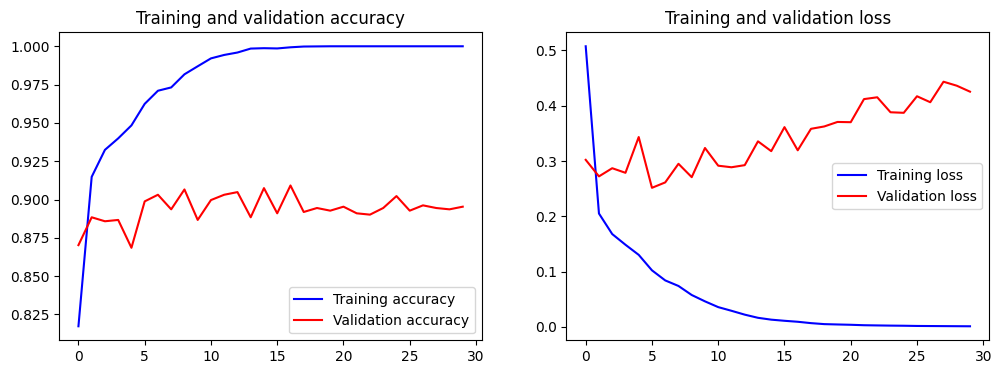

In [15]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import time

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Found 561 images belonging to 2 classes.
5/5 [==============================] - 4s 703ms/step - loss: 0.6943 - accuracy: 0.8877
Test Accuracy: 0.8877005577087402
5/5 [==============================] - 4s 668ms/step


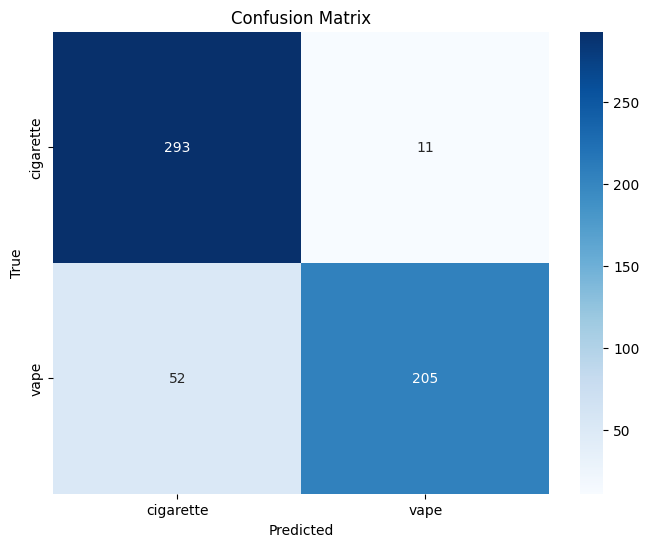

              precision    recall  f1-score   support

   cigarette       0.85      0.96      0.90       304
        vape       0.95      0.80      0.87       257

    accuracy                           0.89       561
   macro avg       0.90      0.88      0.88       561
weighted avg       0.89      0.89      0.89       561

{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}


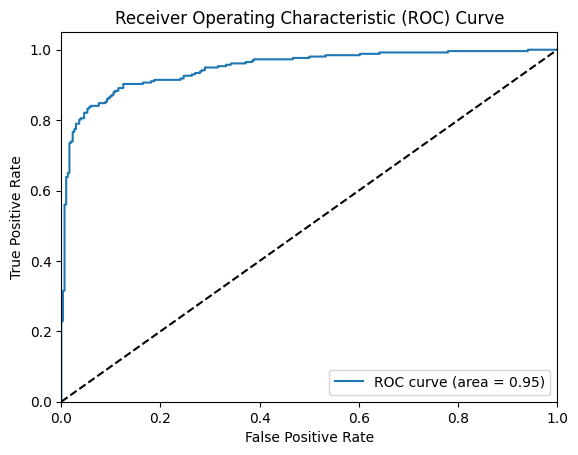

In [14]:
# 모델 평가
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=128, class_mode='binary', shuffle = False)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = np.round(Y_pred,0)

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

# 클래스 인덱스 확인
class_indices = test_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = test_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, Y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#inceptionV3 - 2class 학습(ciga, vape)

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

Found 12030 images belonging to 2 classes.
Found 1156 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표
    patience=10,         # 개선되지 않더라도 기다리는 에포크 수
    min_delta=0.001,     # 성능 향상으로 간주할 최소 변화량
    restore_best_weights=True,  # 성능이 가장 좋았던 가중치 복원
    mode='min'           # 'val_loss'는 최소화를 목표로 함
)

learning_rate = 0.00001
optimizer = Adam(learning_rate=learning_rate)

#***경로 변경***
model_name = 'InceptionV3_2class(vape,cigarette)'
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/'+model_name,
                             monitor='val_loss',
                             save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks = [checkpoint,early_stopping])

Epoch 1/50
376/376 [==============================] - 159s 412ms/step - loss: 0.4700 - accuracy: 0.7839 - val_loss: 0.4065 - val_accuracy: 0.8183
Epoch 2/50
376/376 [==============================] - 89s 236ms/step - loss: 0.2890 - accuracy: 0.8895 - val_loss: 0.3379 - val_accuracy: 0.8503
Epoch 3/50
376/376 [==============================] - 90s 240ms/step - loss: 0.2400 - accuracy: 0.9084 - val_loss: 0.3088 - val_accuracy: 0.8599
Epoch 4/50
376/376 [==============================] - 89s 237ms/step - loss: 0.2132 - accuracy: 0.9190 - val_loss: 0.2859 - val_accuracy: 0.8737
Epoch 5/50
376/376 [==============================] - 89s 236ms/step - loss: 0.1953 - accuracy: 0.9255 - val_loss: 0.2806 - val_accuracy: 0.8720
Epoch 6/50
376/376 [==============================] - 87s 232ms/step - loss: 0.1816 - accuracy: 0.9308 - val_loss: 0.2710 - val_accuracy: 0.8841
Epoch 7/50
376/376 [==============================] - 67s 179ms/step - loss: 0.1700 - accuracy: 0.9347 - val_loss: 0.2786 - val_a

Found 561 images belonging to 2 classes.
18/18 [==============================] - 4s 136ms/step - loss: 0.3362 - accuracy: 0.8467
Test Accuracy: 0.8467023372650146
18/18 [==============================] - 4s 139ms/step


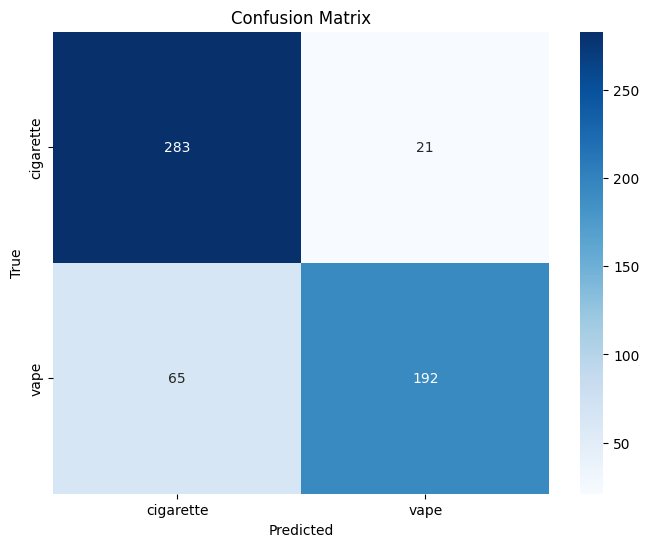

              precision    recall  f1-score   support

   cigarette       0.81      0.93      0.87       304
        vape       0.90      0.75      0.82       257

    accuracy                           0.85       561
   macro avg       0.86      0.84      0.84       561
weighted avg       0.85      0.85      0.84       561

{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}


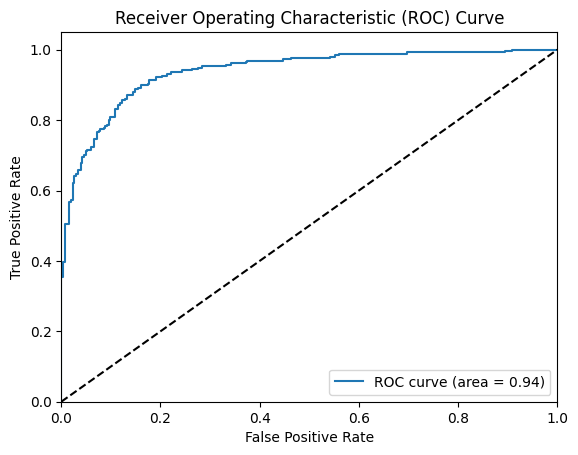

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
test_dir = os.path.join(base_dir, 'test')

# 데이터 로드
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

# 저장된 모델 불러오기
model_path = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/InceptionV3_2class(vape,cigarette)'
model = tf.keras.models.load_model(model_path)

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()  # 임계값 0.5로 이진화

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

# 클래스 인덱스 확인
class_indices = test_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = test_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, Y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


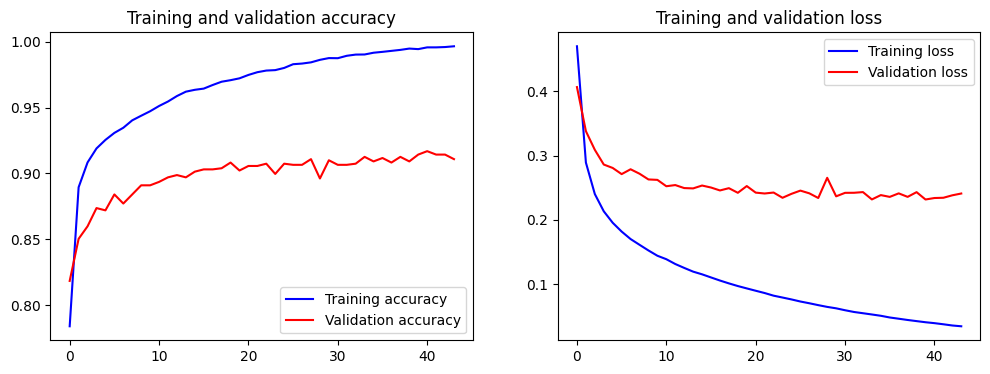

18/18 [==============================] - 3s 154ms/step - loss: 0.3169 - accuracy: 0.8877
Test Accuracy: 0.8877005577087402
18/18 [==============================] - 4s 151ms/step


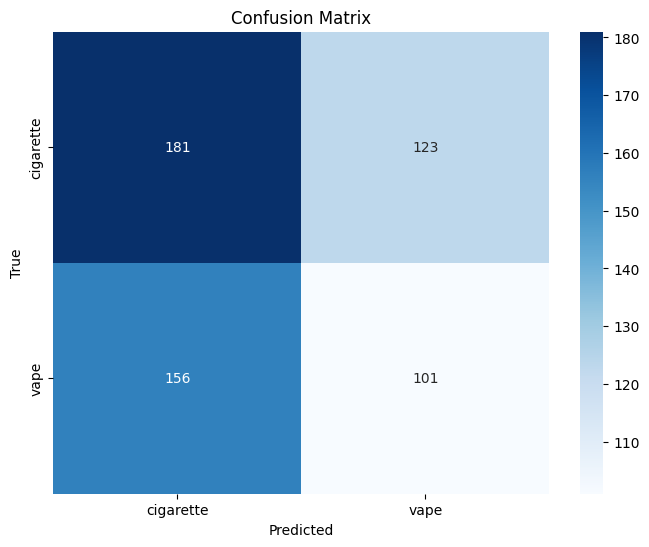

              precision    recall  f1-score   support

   cigarette       0.54      0.60      0.56       304
        vape       0.45      0.39      0.42       257

    accuracy                           0.50       561
   macro avg       0.49      0.49      0.49       561
weighted avg       0.50      0.50      0.50       561



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = np.round(Y_pred).astype(int).flatten()

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)


{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}
37/37 [==============================] - 6s 149ms/step


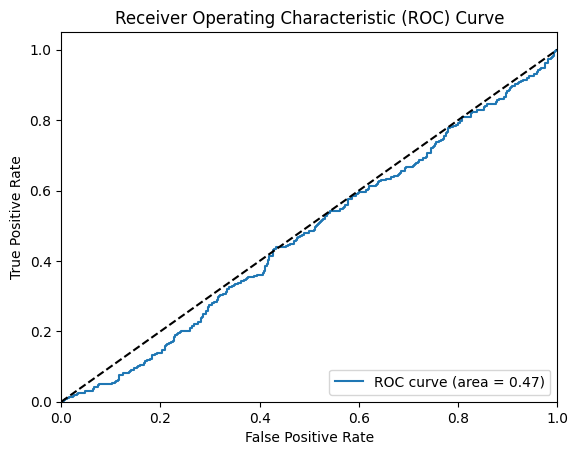

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 예측 확률 값 얻기
y_pred_prob = model.predict(valid_generator)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = valid_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 모델 로드
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/InceptionV3_2class(vape,cigarette)')

# 테스트 데이터 생성기 설정
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/2class/test/',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# 클래스 인덱스와 클래스 이름 매핑 출력
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)

# 예측 수행
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# 이미지 경로 가져오기
image_paths = test_generator.filepaths

# 이미지 예측 및 시각화
num_images = len(image_paths)
num_cols = 5
images_per_page = num_cols * num_cols

for start in range(0, num_images, images_per_page):
    end = min(start + images_per_page, num_images)
    plt.figure(figsize=(20, 20))

    for i, img_path in enumerate(image_paths[start:end]):
        plt.subplot(num_cols, num_cols, i + 1)
        predicted_class = predicted_classes[start + i]
        predicted_class_name = class_names[predicted_class]

        img = image.load_img(img_path, target_size=(224, 224))
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

#inceptionV3 - 2class 학습(ciga, vape) - 학습률 낮게

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/프로그래머스/3차프로젝트/2class'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

Found 12030 images belonging to 2 classes.
Found 1156 images belonging to 2 classes.
Found 561 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표
    patience=10,         # 개선되지 않더라도 기다리는 에포크 수
    min_delta=0.001,     # 성능 향상으로 간주할 최소 변화량
    restore_best_weights=True,  # 성능이 가장 좋았던 가중치 복원
    mode='min'           # 'val_loss'는 최소화를 목표로 함
)

learning_rate = 0.000001
optimizer = Adam(learning_rate=learning_rate)

#***경로 변경***
model_name = 'InceptionV3_2class(vape,cigarette)'
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/'+model_name,
                             monitor='val_loss',
                             save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks = [checkpoint,early_stopping])

Epoch 1/50
376/376 [==============================] - 165s 426ms/step - loss: 0.6536 - accuracy: 0.6245 - val_loss: 0.5994 - val_accuracy: 0.6721
Epoch 2/50
376/376 [==============================] - 92s 243ms/step - loss: 0.5385 - accuracy: 0.7402 - val_loss: 0.5392 - val_accuracy: 0.7240
Epoch 3/50
376/376 [==============================] - 91s 243ms/step - loss: 0.4744 - accuracy: 0.7922 - val_loss: 0.5000 - val_accuracy: 0.7543
Epoch 4/50
376/376 [==============================] - 90s 240ms/step - loss: 0.4306 - accuracy: 0.8160 - val_loss: 0.4691 - val_accuracy: 0.7760
Epoch 5/50
376/376 [==============================] - 91s 242ms/step - loss: 0.3984 - accuracy: 0.8324 - val_loss: 0.4475 - val_accuracy: 0.7889
Epoch 6/50
376/376 [==============================] - 92s 245ms/step - loss: 0.3733 - accuracy: 0.8443 - val_loss: 0.4269 - val_accuracy: 0.8036
Epoch 7/50
376/376 [==============================] - 92s 245ms/step - loss: 0.3531 - accuracy: 0.8563 - val_loss: 0.4137 - val_a

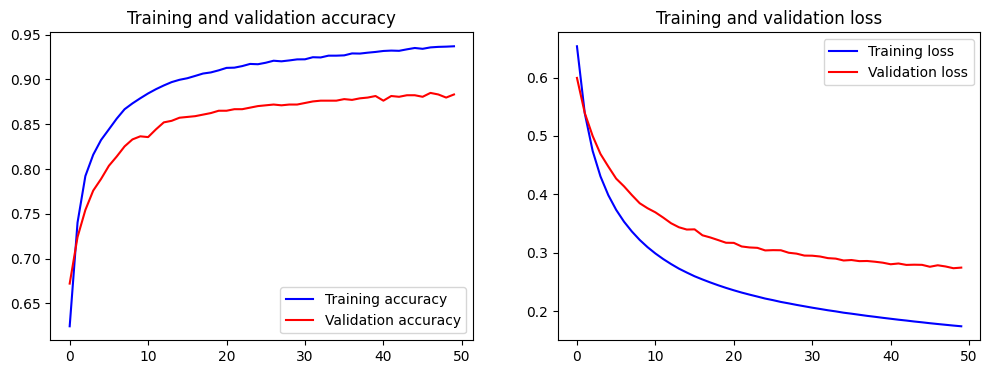

18/18 [==============================] - 3s 151ms/step - loss: 0.3405 - accuracy: 0.8414
Test Accuracy: 0.8413547277450562
18/18 [==============================] - 4s 151ms/step


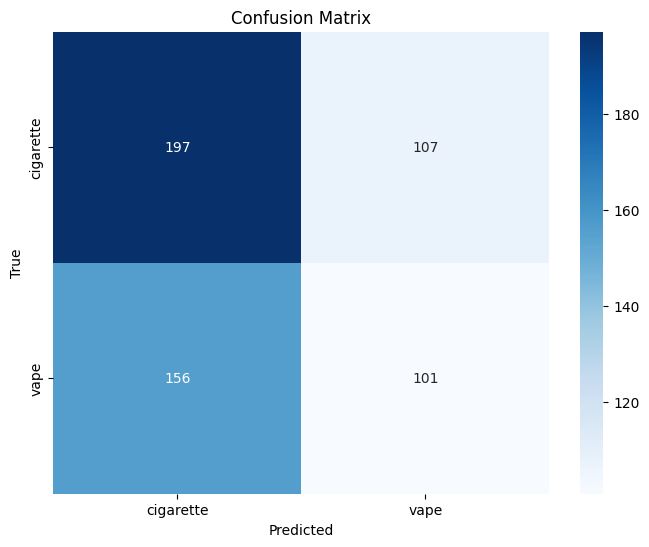

              precision    recall  f1-score   support

   cigarette       0.56      0.65      0.60       304
        vape       0.49      0.39      0.43       257

    accuracy                           0.53       561
   macro avg       0.52      0.52      0.52       561
weighted avg       0.52      0.53      0.52       561



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time

# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = np.round(Y_pred).astype(int).flatten()

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)


{'cigarette': 0, 'vape': 1}
{0: 'cigarette', 1: 'vape'}
37/37 [==============================] - 6s 156ms/step


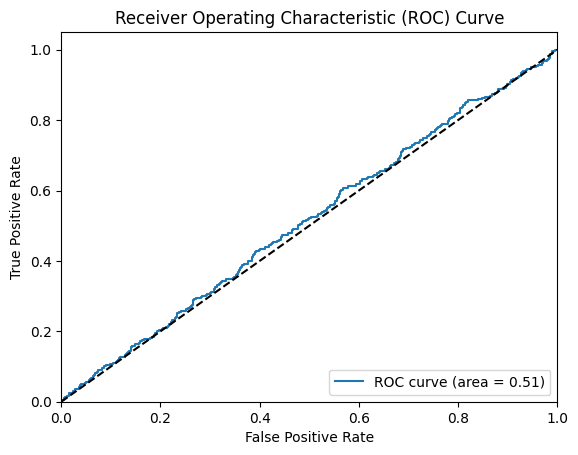

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

# 예측 확률 값 얻기
y_pred_prob = model.predict(valid_generator)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = valid_generator.classes

# 이진 분류의 경우, 하나의 ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(y_val_labels, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 모델 로드
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/InceptionV3_2class(vape,cigarette)')

# 테스트 데이터 생성기 설정
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/2class/test/',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# 클래스 인덱스와 클래스 이름 매핑 출력
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)

# 예측 수행
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# 이미지 경로 가져오기
image_paths = test_generator.filepaths

# 이미지 예측 및 시각화
num_images = len(image_paths)
num_cols = 5
images_per_page = num_cols * num_cols

for start in range(0, num_images, images_per_page):
    end = min(start + images_per_page, num_images)
    plt.figure(figsize=(20, 20))

    for i, img_path in enumerate(image_paths[start:end]):
        plt.subplot(num_cols, num_cols, i + 1)
        predicted_class = predicted_classes[start + i]
        predicted_class_name = class_names[predicted_class]

        img = image.load_img(img_path, target_size=(224, 224))
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


#inceptionV3 - 2class 학습(smoking, nonsmoking)

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경로 설정
base_dir = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/2class(smoking-nonsmoking)'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# 이미지 데이터 제너레이터 설정
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

Found 11902 images belonging to 2 classes.
Found 2046 images belonging to 2 classes.
Found 1060 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 새로운 레이어 추가
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 이전 레이어들의 학습을 동결
for layer in base_model.layers:
    layer.trainable = False

early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링할 지표
    patience=5,         # 개선되지 않더라도 기다리는 에포크 수
    min_delta=0.001,     # 성능 향상으로 간주할 최소 변화량
    restore_best_weights=True,  # 성능이 가장 좋았던 가중치 복원
    mode='min'           # 'val_loss'는 최소화를 목표로 함
)

#***경로 변경***
model_name = 'InceptionV3_2class(smoking,nonsmoking)'
checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/'+model_name,
                             monitor='val_loss',
                             save_best_only=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks = [checkpoint,early_stopping])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import time
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 모델 평가
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# 예측 값 계산
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(test_generator.classes, y_pred, target_names=class_names)
print(report)

In [ ]:
# 클래스 인덱스 확인
class_indices = train_generator.class_indices
print(class_indices)

# 인덱스와 클래스 이름 매핑
index_to_class = {v: k for k, v in class_indices.items()}
print(index_to_class)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 예측 확률 값 얻기
y_pred_prob = model.predict(valid_generator)

# 레이블 원-핫 인코딩을 원래 레이블로 변환
y_val_labels = valid_generator.classes

# ROC 곡선 및 AUC 계산
fpr = {}
tpr = {}
roc_auc = {}

for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_labels == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {index_to_class[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 모델 로드
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/3차프로젝트/cnn/checkpoint/InceptionV3_2class(smoking,nonsmoking)')

# 테스트 데이터 생성기 설정
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/3차프로젝트/2class(smoking-nonsmoking)/test/',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# 클래스 인덱스와 클래스 이름 매핑 출력
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}
print("Class indices:", class_indices)

# 예측 수행
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# 이미지 경로 가져오기
image_paths = test_generator.filepaths

# 이미지 예측 및 시각화
num_images = len(image_paths)
num_cols = 5
images_per_page = num_cols * num_cols

for start in range(0, num_images, images_per_page):
    end = min(start + images_per_page, num_images)
    plt.figure(figsize=(20, 20))

    for i, img_path in enumerate(image_paths[start:end]):
        plt.subplot(num_cols, num_cols, i + 1)
        predicted_class = predicted_classes[start + i]
        predicted_class_name = class_names[predicted_class]

        img = image.load_img(img_path, target_size=(224, 224))
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.